# Dependencies

In [1]:
import os
import sys

sys.path.append(os.getcwd().split('notebooks')[0])

from notebooks.utilities.utils import *

Device: cpu


In [2]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

# Load Tensor

### Non Deep Learning

In [3]:
# original_tensor = torch.stack((torch.load(f"{meta_data_folder}non_deep/DT_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/RF_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/ET_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/GB_Spambase_829.pt")))

# # original_tensor = original_tensor[:, :, 0, :, :, :].clone()          # very good one
# # original_tensor = original_tensor[:, 2, 0, :, 1:, 2:].clone() 

In [4]:
# original_tensor = torch.stack((
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/RF_Alzheimers_903.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/RF_Particle_ID_903_025.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/RF_Spambase_903.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/RF_Biodeg_904.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/RF_Dermatology_904.pt"),
#                                ))

# original_tensor = original_tensor[:, 4, :, :, :].clone()

In [5]:
# original_tensor = torch.stack((
#                                torch.load(f"{meta_data_folder}non_deep/SVM_Biodeg_905.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/SVM_Alzheimers_905.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/SVM_Dermatology_905.pt"),
#                                ))

# original_tensor = original_tensor[:, 1:, :, :, :, :].clone()

In [6]:
# original_tensor = torch.stack((torch.load(f"{meta_data_folder}non_deep/dataset_mode/KNN_Alzheimers_902.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/KNN_Biodeg_904.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/dataset_mode/KNN_Dermatology_904.pt")))

### Deep Learning

In [7]:
original_tensor = torch.stack((
                               torch.load(f"{meta_data_folder}deep_learning/FCNN_Spambase_902.pt"),
                               torch.load(f"{meta_data_folder}deep_learning/FCNN_Particle_ID_903_02.pt"),
                               torch.load(f"{meta_data_folder}deep_learning/FCNN_Alzheimers_902.pt"),
                               torch.load(f"{meta_data_folder}deep_learning/FCNN_car_evaluation_903.pt"),
                               torch.load(f"{meta_data_folder}deep_learning/FCNN_Dermatology_903.pt")
                               ))

original_tensor = original_tensor[:, 0, : , :, :, :].clone()

### Looking at tensor

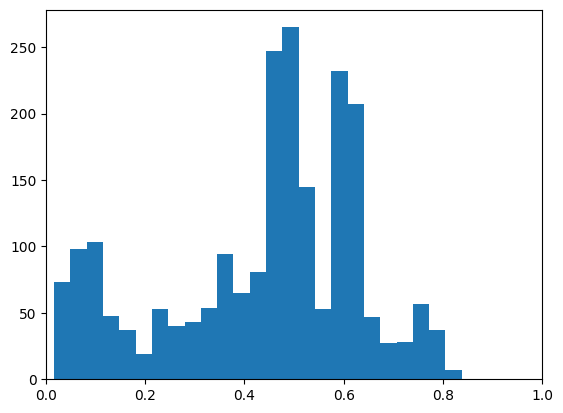

In [8]:
plt.hist(original_tensor.flatten(), bins = 25)
plt.xlim(0, 1)

plt.show()

In [9]:
print(f"Tensor shape: {original_tensor.shape}")
total_cells = 1
for s in original_tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([5, 6, 3, 6, 4])
2160 total cells in tensor.


# Train & Evaluate

In [10]:
num_epochs = 10000
batch_size = 256
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

portions = [0.005, 0.01, 0.02, 0.03, 0.05]

costco_rank = 32
cpd_rank = 3

In [11]:
empty_slice = 2
other_slice_portion = 0.15

In [12]:
MAEs = list()

for portion in portions:

        it_MAEs = list()
        
        print(f"Portion {portion} iteration:", end = " ")
        for it in range(1, num_iterations+1):
                model_MAEs = list()
                
# __________________________________________________________________________________________________________________________________________________________

                sparse_tensor = get_sparse_tensor(t = original_tensor[empty_slice, :, :, :].clone(),
                                                  portion = portion,
                                                  verbose = False)

                model = ETC(sparse_tensor = sparse_tensor,
                            models_type_rank = [
                                                'cpd.smooth_1', 'cpd.smooth_3', 'cpd.smooth_5', 'cpd.smooth_10'
                                               ],
                            
                            num_splits = 10,
                            use_unique_train_values = False,
                            use_all_train_values = False,
                            mlp_hidden_dim1 = 128,
                            mlp_hidden_dim2 = None,
                            agg_func = 'mlp',
                            dropout_p = 0.0,
                            dropout_p_before_mlp = 0.0,
                            lr = lr,
                            wd = wd,
                            num_epochs = num_epochs,
                            batch_size = batch_size,
                            further_train_individuals = False,
                            device = device)
                                                
                model = train_learned_ensemble(model = model,
                                               sparse_tensor = sparse_tensor,
                                               lr = lr,
                                               wd = lr,
                                               num_epochs = num_epochs,
                                               batch_size = batch_size,
                                               flags = 50,
                                               early_stopping = True,
                                               val_size = 0.2,
                                               device = device)
                
                
                model_MAEs += [get_unique_MAE(model,
                                              full_t = original_tensor[empty_slice, :, :, :],
                                              sparse_t = sparse_tensor)]     
                
                del model
                
                
                del sparse_tensor
                
# __________________________________________________________________________________________________________________________________________________________
                
                sim_portions = [other_slice_portion for x in range(original_tensor.shape[0])]
                
                sim_portions[empty_slice] = portion
                                
                biased_sparse_tensor = get_simulated_sparse_tensor(t = original_tensor.clone(),
                                                                   portions = sim_portions)

                
                
                model = ETC(sparse_tensor = biased_sparse_tensor,
                            models_type_rank = [
                                                'cpd.smooth_1', 'cpd.smooth_3', 'cpd.smooth_5', 'cpd.smooth_10'
                                               ],
                            
                            num_splits = 10,
                            use_unique_train_values = False,
                            use_all_train_values = False,
                            mlp_hidden_dim1 = 128,
                            mlp_hidden_dim2 = None,
                            agg_func = 'mlp',
                            dropout_p = 0.0,
                            dropout_p_before_mlp = 0.0,
                            lr = lr,
                            wd = wd,
                            num_epochs = num_epochs,
                            batch_size = batch_size,
                            further_train_individuals = False,
                            device = device)
                               
                                                
                model = train_learned_ensemble(model = model,
                                               sparse_tensor = biased_sparse_tensor,
                                               lr = lr,
                                               wd = lr,
                                               num_epochs = num_epochs,
                                               batch_size = batch_size,
                                               flags = 50,
                                               early_stopping = True,
                                               val_size = 0.2,
                                               device = device)
                
                
                model_MAEs += [get_slice_MAE(model = model, 
                                             full_t = original_tensor, 
                                             sparse_t = biased_sparse_tensor,
                                             slice = empty_slice)]  
                
                del model
                
                del biased_sparse_tensor

                it_MAEs += [model_MAEs]
                
# __________________________________________________________________________________________________________________________________________________________

                if (it == num_iterations): print(it)
                else: print(it, end = ", ")

        MAEs += [it_MAEs]

MAEs = np.array(MAEs)

print("\nAll done!")

Portion 0.005 iteration: 1, 2, 3, 4, 5
Portion 0.01 iteration: 1, 2, 3, 4, 5
Portion 0.02 iteration: 1, 2, 

KeyboardInterrupt: 

In [ ]:
labels = [
          'No Dataset Mode',
          'Dataset Mode'
          ]

In [ ]:
avgs = MAEs.mean(axis = 1)
sds = MAEs.std(axis = 1)

# Plot Results

In [ ]:
colors = ['black', 'green']

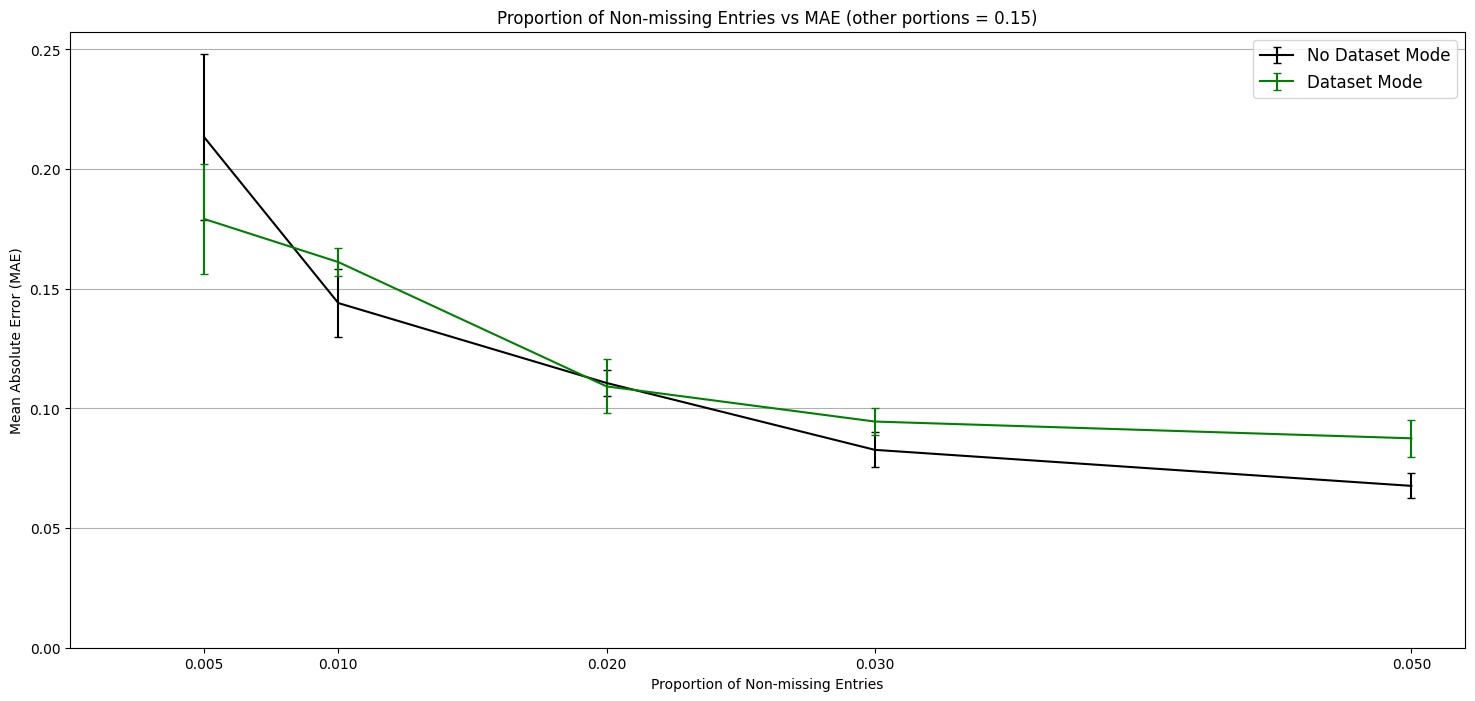

In [ ]:
x = portions

plt.figure(figsize=(18, 8))

for i in range(avgs.shape[-1]):
    plt.errorbar(x, avgs[:, i], yerr=sds[:, i], color = colors[i], label=labels[i], capsize=3)

plt.xlabel('Proportion of Non-missing Entries')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title(f'Proportion of Non-missing Entries vs MAE (other portions = {other_slice_portion})')

plt.xticks([t for t in portions])
plt.legend(fontsize = 12)
plt.grid(axis = 'y')

plt.xlim(0, portions[-1]+(portions[-1]/25))
# plt.ylim(0.1, 0.2)
# plt.ylim(0, 0.25)
plt.ylim(bottom = 0)

plt.show()